In [1]:
import random
from collections import defaultdict
from math import sqrt, pi, e
import math
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import plotly.express as px
from prophet import Prophet

In [2]:
"""
    Load PDCE data and analyze it
"""

df = pd.read_excel('oil_gas_train/PDCE.xlsx')
data = df.to_numpy()

# removing extra cells in a file
data = data[26:, 8:]
data[0, 0] = 'Quarters'

In [3]:
"""
    Build dataframe with informative rows
"""

informative_rows = ['Quarters', 'INCOME STATEMENT', 'Revenue', 'Operating Income', 
                    'Gross Profit', 'Net Income', 'EBITDA', 'Total Equity']
set_rows = set(informative_rows)

st = {data[i, 0]: data[i, 1:] for i, s in enumerate(data[:, 0]) if s in set_rows}
df = pd.DataFrame(st)

df[informative_rows[2:]] = df[informative_rows[2:]].apply(pd.to_numeric)

print(df.dtypes)
df.head()

Quarters                    object
INCOME STATEMENT    datetime64[ns]
Revenue                    float64
Gross Profit               float64
Operating Income           float64
Net Income                 float64
EBITDA                     float64
Total Equity               float64
dtype: object


,Quarters,INCOME STATEMENT,Revenue,Gross Profit,Operating Income,Net Income,EBITDA,Total Equity
0,Q1 '11 A,2011-03-31,79.643,30.186,1.251,-4.74255,33.608,624.600992
1,Q2 '11 A,2011-06-30,88.217,40.730,1.799,-3.14465,34.473,637.390976
2,Q3 '11 A,2011-09-30,95.870,33.476,18.658,5.33335,52.974,671.205008
3,Q4 '11 A,2011-12-31,103.383,47.874,16.213,5.05080,52.020,664.112000
4,Q1 '12 A,2012-03-31,89.432,47.857,20.186,6.07210,60.000,681.232000


In [4]:
"""
    Adding seasonal features
"""

df['q1'] = df['Quarters'].str.contains('Q1', regex=False).astype(int)
df['q2'] = df['Quarters'].str.contains('Q2', regex=False).astype(int)
df['q3'] = df['Quarters'].str.contains('Q3', regex=False).astype(int)
df['q4'] = df['Quarters'].str.contains('Q4', regex=False).astype(int)

df.head()

,Quarters,INCOME STATEMENT,Revenue,Gross Profit,Operating Income,Net Income,EBITDA,Total Equity,q1,q2,q3,q4
0,Q1 '11 A,2011-03-31,79.643,30.186,1.251,-4.74255,33.608,624.600992,1,0,0,0
1,Q2 '11 A,2011-06-30,88.217,40.730,1.799,-3.14465,34.473,637.390976,0,1,0,0
2,Q3 '11 A,2011-09-30,95.870,33.476,18.658,5.33335,52.974,671.205008,0,0,1,0
3,Q4 '11 A,2011-12-31,103.383,47.874,16.213,5.05080,52.020,664.112000,0,0,0,1
4,Q1 '12 A,2012-03-31,89.432,47.857,20.186,6.07210,60.000,681.232000,1,0,0,0


In [5]:
"""
    We add time-step feature, which is dummy variable indicating time
"""

df['Time'] = np.arange(len(df.index))

df.head()

,Quarters,INCOME STATEMENT,Revenue,Gross Profit,Operating Income,Net Income,EBITDA,Total Equity,q1,q2,q3,q4,Time
0,Q1 '11 A,2011-03-31,79.643,30.186,1.251,-4.74255,33.608,624.600992,1,0,0,0,0
1,Q2 '11 A,2011-06-30,88.217,40.730,1.799,-3.14465,34.473,637.390976,0,1,0,0,1
2,Q3 '11 A,2011-09-30,95.870,33.476,18.658,5.33335,52.974,671.205008,0,0,1,0,2
3,Q4 '11 A,2011-12-31,103.383,47.874,16.213,5.05080,52.020,664.112000,0,0,0,1,3
4,Q1 '12 A,2012-03-31,89.432,47.857,20.186,6.07210,60.000,681.232000,1,0,0,0,4


Text(0.5, 1.0, 'Time Plot of Operating Income')

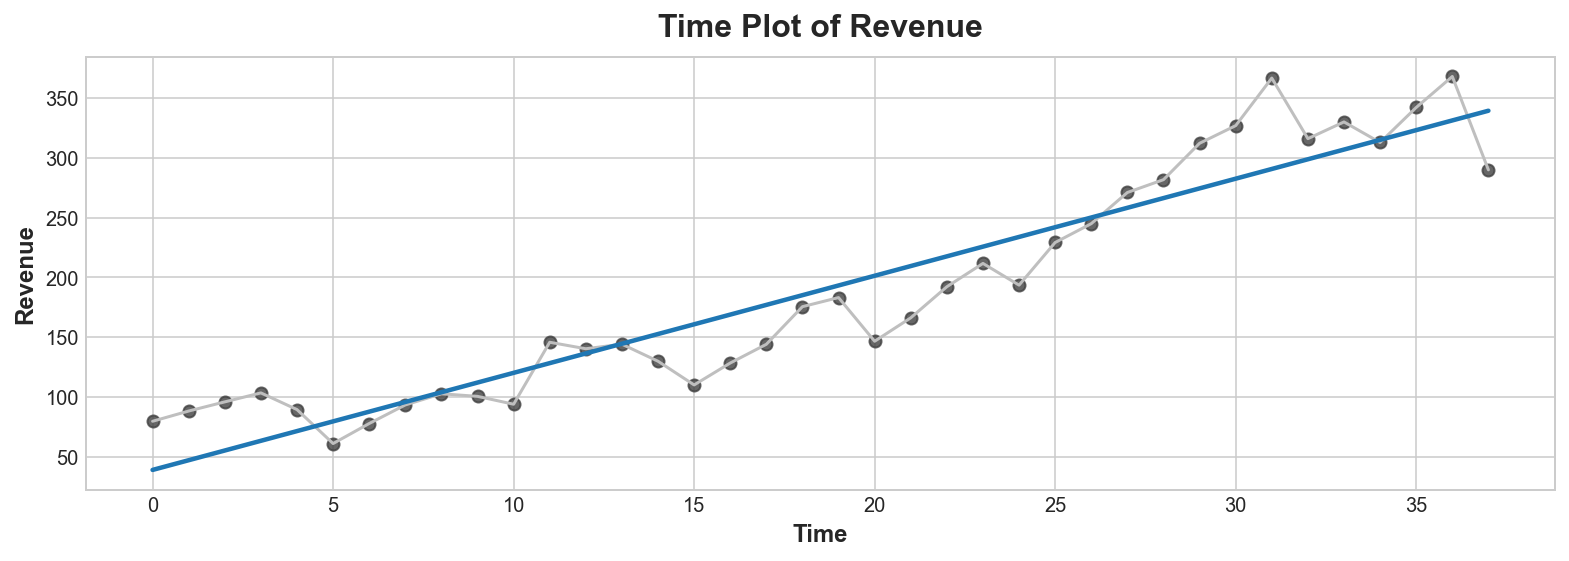

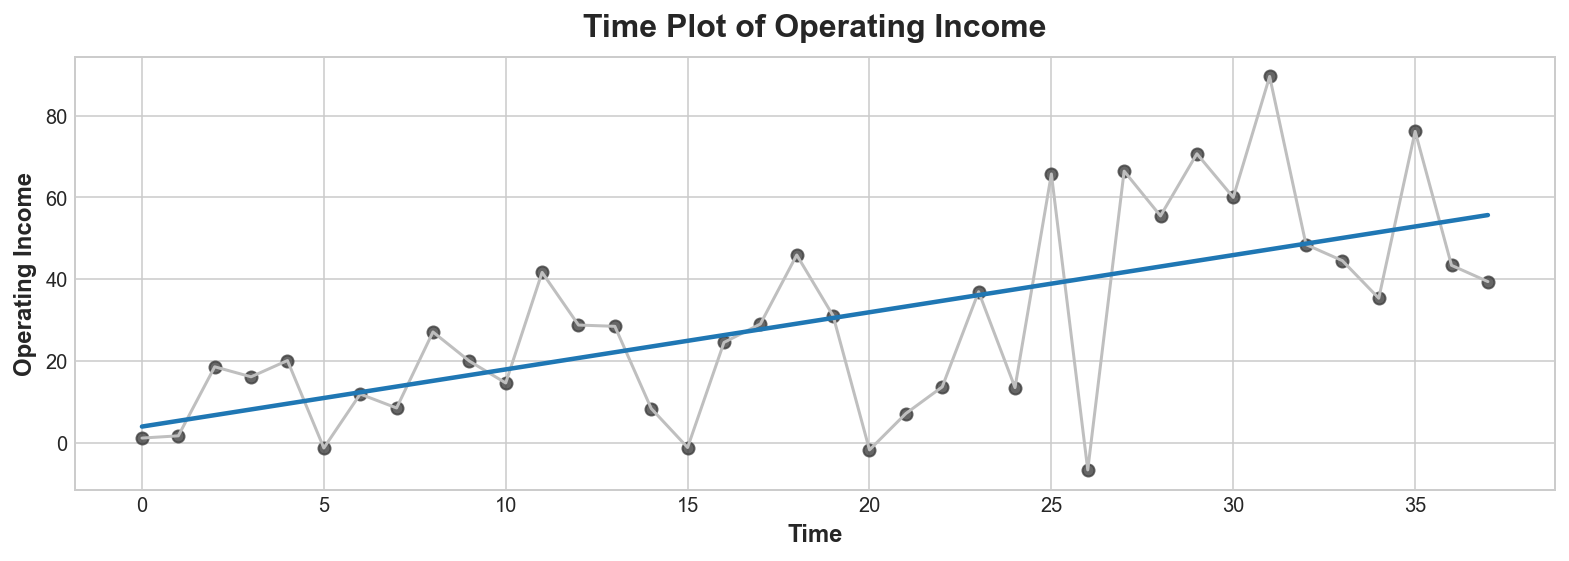

In [6]:
"""
    Linear regression from time-step to Revenue and Operating Income
    We model the Trend
"""

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4), titlesize=18, titleweight='bold')
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)
%config InlineBackend.figure_format = 'retina'

fig, ax = plt.subplots()
ax.plot('Time', 'Revenue', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Revenue', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Revenue')

fig, ax = plt.subplots()
ax.plot('Time', 'Operating Income', data=df, color='0.75')
ax = sns.regplot(x='Time', y='Operating Income', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_title('Time Plot of Operating Income')

In [7]:
"""
    We will not have access to informative rows at present time
    Thus we need to take lag and drop them
"""

informative_features = informative_rows[4:]

for ir in informative_features:
    df['lag1_' + ir] = df[ir].shift(1).fillna(0.0)

df = df.drop(columns=informative_features)    
df.head()
    

,Quarters,INCOME STATEMENT,Revenue,Operating Income,q1,q2,q3,q4,Time,lag1_Gross Profit,lag1_Net Income,lag1_EBITDA,lag1_Total Equity
0,Q1 '11 A,2011-03-31,79.643,1.251,1,0,0,0,0,0.000,0.00000,0.000,0.000000
1,Q2 '11 A,2011-06-30,88.217,1.799,0,1,0,0,1,30.186,-4.74255,33.608,624.600992
2,Q3 '11 A,2011-09-30,95.870,18.658,0,0,1,0,2,40.730,-3.14465,34.473,637.390976
3,Q4 '11 A,2011-12-31,103.383,16.213,0,0,0,1,3,33.476,5.33335,52.974,671.205008
4,Q1 '12 A,2012-03-31,89.432,20.186,1,0,0,0,4,47.874,5.05080,52.020,664.112000


In [8]:
"""
    We make lag-1, lag-2, lag-3, lag-4 features. Shifted Revenue and Operating Income
"""

for i in range(1, 5):
    df['lag%d_' % i + 'Revenue'] = df['Revenue'].shift(i).fillna(0.0)
    df['lag%d_' % i + 'Operating Income'] = df['Operating Income'].shift(i).fillna(0.0)

df.head()

,Quarters,INCOME STATEMENT,Revenue,Operating Income,q1,q2,q3,q4,Time,lag1_Gross Profit,...,lag1_EBITDA,lag1_Total Equity,lag1_Revenue,lag1_Operating Income,lag2_Revenue,lag2_Operating Income,lag3_Revenue,lag3_Operating Income,lag4_Revenue,lag4_Operating Income
0,Q1 '11 A,2011-03-31,79.643,1.251,1,0,0,0,0,0.000,...,0.000,0.000000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
1,Q2 '11 A,2011-06-30,88.217,1.799,0,1,0,0,1,30.186,...,33.608,624.600992,79.643,1.251,0.000,0.000,0.000,0.000,0.000,0.000
2,Q3 '11 A,2011-09-30,95.870,18.658,0,0,1,0,2,40.730,...,34.473,637.390976,88.217,1.799,79.643,1.251,0.000,0.000,0.000,0.000
3,Q4 '11 A,2011-12-31,103.383,16.213,0,0,0,1,3,33.476,...,52.974,671.205008,95.870,18.658,88.217,1.799,79.643,1.251,0.000,0.000
4,Q1 '12 A,2012-03-31,89.432,20.186,1,0,0,0,4,47.874,...,52.020,664.112000,103.383,16.213,95.870,18.658,88.217,1.799,79.643,1.251


Text(0.5, 1.0, 'Lag_1 to Operating Income')

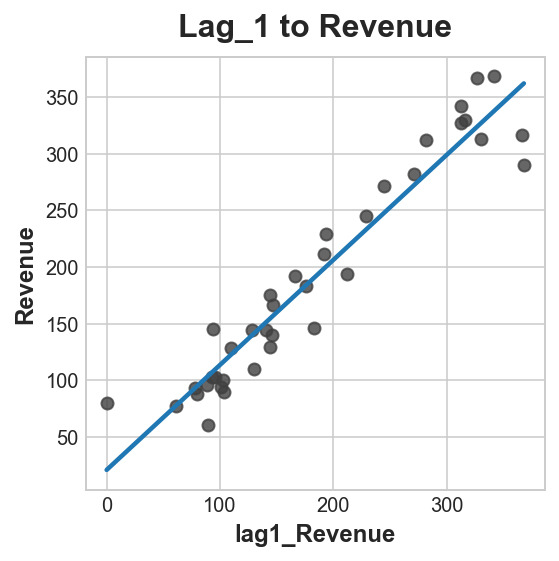

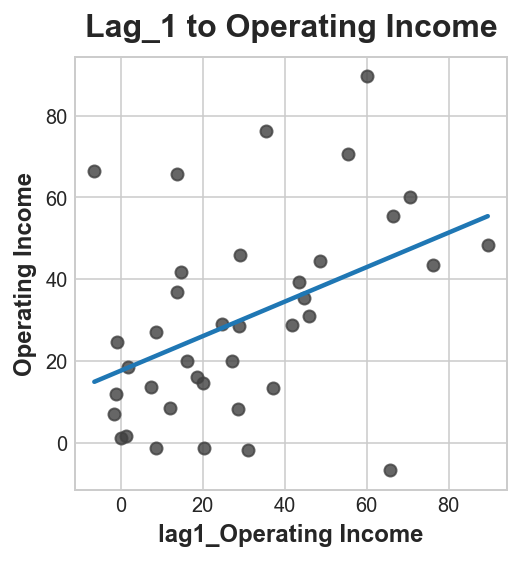

In [9]:
"""
    See how predictive are previous values
    Make regression from Lag_1 to present values of Revenue and Operating Income
    We will see that lag_1 features are collinear with present value
"""

fig, ax = plt.subplots()
ax = sns.regplot(x='lag1_Revenue', y='Revenue', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag_1 to Revenue')

fig, ax = plt.subplots()
ax = sns.regplot(x='lag1_Operating Income', y='Operating Income', data=df, ci=None, scatter_kws=dict(color='0.25'))
ax.set_aspect('equal')
ax.set_title('Lag_1 to Operating Income')


In [10]:
print(df.columns)
print(len(df.columns))

Index(['Quarters', 'INCOME STATEMENT', 'Revenue', 'Operating Income', 'q1',
       'q2', 'q3', 'q4', 'Time', 'lag1_Gross Profit', 'lag1_Net Income',
       'lag1_EBITDA', 'lag1_Total Equity', 'lag1_Revenue',
       'lag1_Operating Income', 'lag2_Revenue', 'lag2_Operating Income',
       'lag3_Revenue', 'lag3_Operating Income', 'lag4_Revenue',
       'lag4_Operating Income'],
      dtype='object')
21


In [11]:
"""
    Train Linear Model
"""

from sklearn.linear_model import LinearRegression

ntest = len(df) // 5

train, test = df[:-ntest], df[-ntest:]
features = df.columns[4:]
targets = ['Revenue', 'Operating Income']

Xtrain = train[features]
Xtest = test[features]

regs = {}

for t in targets:
    ytrain = train[t]
    ytest = test[t]

    regs[t] = LinearRegression().fit(Xtrain, ytrain)
    df['predicted_' + t] = regs[t].predict(df[features])

df.head()

,Quarters,INCOME STATEMENT,Revenue,Operating Income,q1,q2,q3,q4,Time,lag1_Gross Profit,...,lag1_Revenue,lag1_Operating Income,lag2_Revenue,lag2_Operating Income,lag3_Revenue,lag3_Operating Income,lag4_Revenue,lag4_Operating Income,predicted_Revenue,predicted_Operating Income
0,Q1 '11 A,2011-03-31,79.643,1.251,1,0,0,0,0,0.000,...,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,27.148530,-8.311920
1,Q2 '11 A,2011-06-30,88.217,1.799,0,1,0,0,1,30.186,...,79.643,1.251,0.000,0.000,0.000,0.000,0.000,0.000,91.208166,6.313671
2,Q3 '11 A,2011-09-30,95.870,18.658,0,0,1,0,2,40.730,...,88.217,1.799,79.643,1.251,0.000,0.000,0.000,0.000,93.688752,15.983853
3,Q4 '11 A,2011-12-31,103.383,16.213,0,0,0,1,3,33.476,...,95.870,18.658,88.217,1.799,79.643,1.251,0.000,0.000,101.354630,14.073645
4,Q1 '12 A,2012-03-31,89.432,20.186,1,0,0,0,4,47.874,...,103.383,16.213,95.870,18.658,88.217,1.799,79.643,1.251,95.706295,23.236582


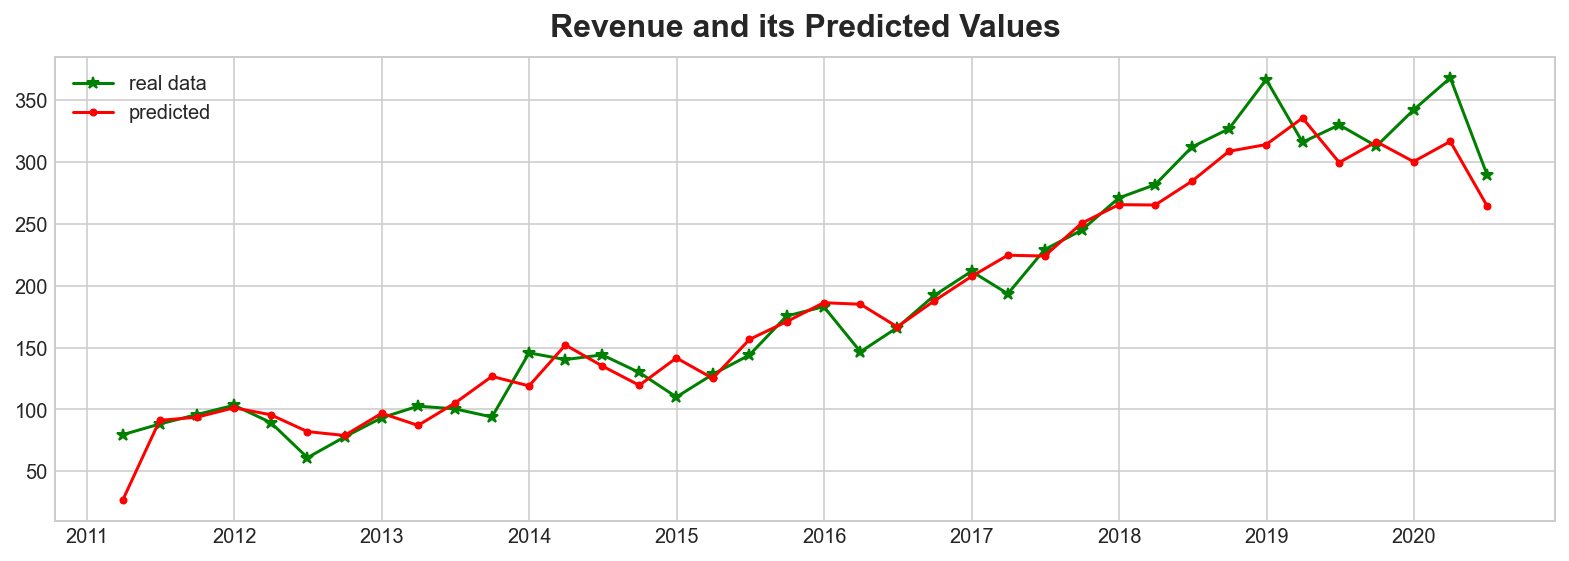

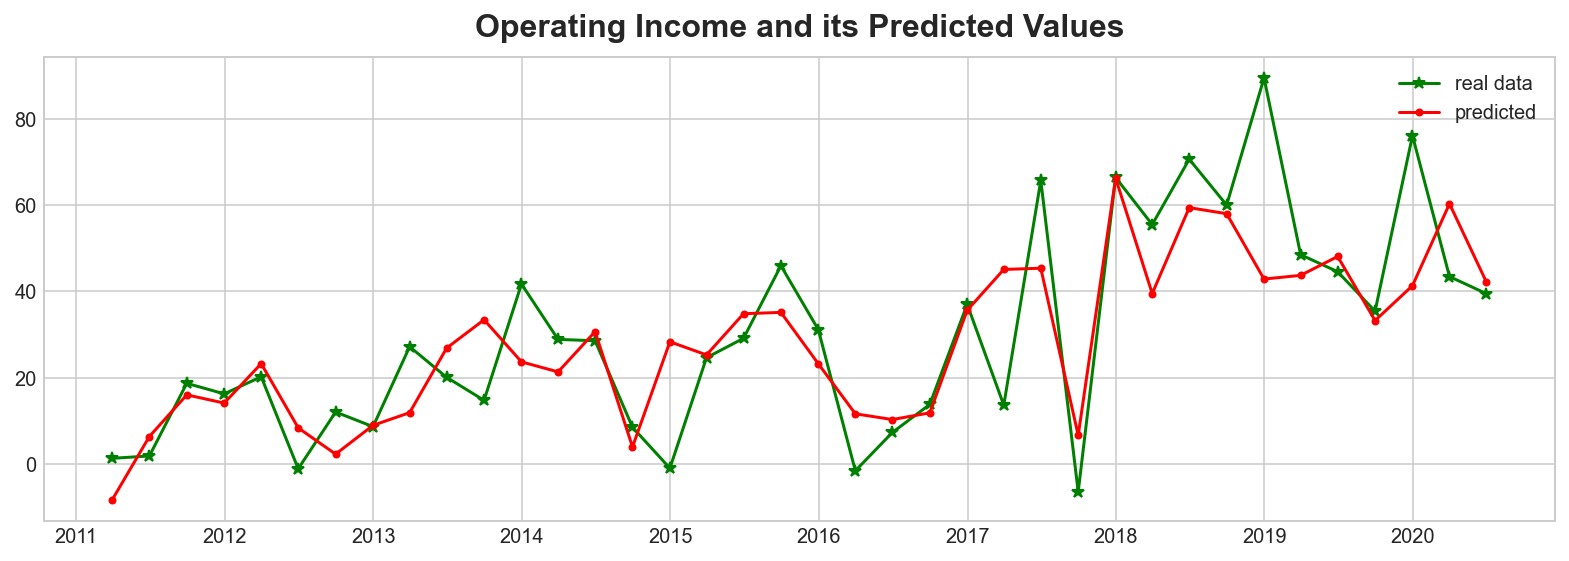

In [14]:
"""
    Plot real data and predicted
"""

plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True, figsize=(11, 4), titlesize=18, titleweight='bold')
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlesize=16, titlepad=10)
%config InlineBackend.figure_format = 'retina'

for t in targets:
    fig, ax = plt.subplots()
    ax.plot('INCOME STATEMENT', t, data=df, color='g', marker='*', label='real data')
    ax.plot('INCOME STATEMENT', 'predicted_' + t, data=df, color='r', marker='.', label='predicted')

    plt.legend()
    ax.set_title('%s and its Predicted Values' % t);

In [13]:
"""
    Get MSE (mean square error) and MAPE (mean absolute percentage error)
    of predictions on validation data
"""

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error

for t in targets:
    print('\nPerformance on %s' % t)
    y_train_true = train[t]
    y_train_pred = regs[t].predict(train[features])

    y_true = test[t]
    y_pred = regs[t].predict(test[features])

    mse_train = mean_squared_error(y_train_true, y_train_pred)
    mse_val = mean_squared_error(y_true, y_pred)

    mape_train = mean_absolute_percentage_error(y_train_true, y_train_pred)
    mape_val = mean_absolute_percentage_error(y_true, y_pred)

    print('MSE on train: %d' % mse_train)
    print('MSE on validation: %d' % mse_val)

    print('MAPE on train: %0.5f' % mape_train)
    print('MAPE on validation: %0.5f' % mape_val)


Performance on Revenue
MSE on train: 348
MSE on validation: 1301
MAPE on train: 0.10779
MAPE on validation: 0.09396

Performance on Operating Income
MSE on train: 148
MSE on validation: 532
MAPE on train: 2.10655
MAPE on validation: 0.23924


<h3> Conclusion </h3>

<p> Looking at errors on train and validation data, we see that current models a bit overfit. We will handle it when training one model on all companies. Currently we trained only on one company. </p>

<p> In this notebook, we picked informative features. Also, we used some feature engineering with lags and seasonality. And trained predictive models on future Revenue and Operating Income targets. </p>